In [3]:
#importing Libraries
import requests
import lxml.html as lh
import bs4 as bs
import urllib.request
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:

#Getting the data from url
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
res = requests.get(url)
soup = bs.BeautifulSoup(res.content,'lxml')
table = soup.find_all('table')[0]
df = pd.read_html(str(table))
data = pd.read_json(df[0].to_json(orient='records'))

In [5]:
#First 5 rows of data frame
data.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [6]:
# removing assigned value from borough coloumn
raw_data_selected = data[data['Borough'] != 'Not assigned']


In [10]:
#Grouping Data with the help of postcode
raw_data_selected = raw_data_selected.groupby(['Borough', 'Postal Code'], as_index=False).agg(','.join)
raw_data_selected.head()

,Borough,Postal Code,Neighbourhood
0,Central Toronto,M4N,Lawrence Park
1,Central Toronto,M4P,Davisville North
2,Central Toronto,M4R,"North Toronto West, Lawrence Park"
3,Central Toronto,M4S,Davisville
4,Central Toronto,M4T,"Moore Park, Summerhill East"


In [11]:
#Replacing values of not assigned in Neighbourhood field with Borough
raw_data_selected['Neighbourhood'] = np.where(raw_data_selected['Neighbourhood'] == 'Not assigned', raw_data_selected['Borough'], raw_data_selected['Neighbourhood'])

In [12]:
# finding the Shape of Data
raw_data_selected.shape

(103, 3)

In [13]:
geospatial_url = "https://cocl.us/Geospatial_data"
geospatial_data = pd.read_csv(geospatial_url)

In [14]:
geospatial_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [21]:
data = pd.merge(raw_data_selected, geospatial_data, on='Postal Code')
data.head()

,Borough,Postal Code,Neighbourhood,Latitude,Longitude
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678
3,Central Toronto,M4S,Davisville,43.704324,-79.388790
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160


In [22]:
data['Coordinates'] = list(zip(data['Latitude'], data['Longitude']))
data.head()

,Borough,Postal Code,Neighbourhood,Latitude,Longitude,Coordinates
0,Central Toronto,M4N,Lawrence Park,43.728020,-79.388790,"(43.7280205, -79.3887901)"
1,Central Toronto,M4P,Davisville North,43.712751,-79.390197,"(43.7127511, -79.3901975)"
2,Central Toronto,M4R,"North Toronto West, Lawrence Park",43.715383,-79.405678,"(43.7153834, -79.40567840000001)"
3,Central Toronto,M4S,Davisville,43.704324,-79.388790,"(43.7043244, -79.3887901)"
4,Central Toronto,M4T,"Moore Park, Summerhill East",43.689574,-79.383160,"(43.6895743, -79.38315990000001)"


In [23]:
data.isnull().sum()

Borough          0
Postal Code      0
Neighbourhood    0
Latitude         0
Longitude        0
Coordinates      0
dtype: int64

In [24]:
x=data[['Latitude','Longitude']]

In [25]:
import matplotlib.pyplot as plt

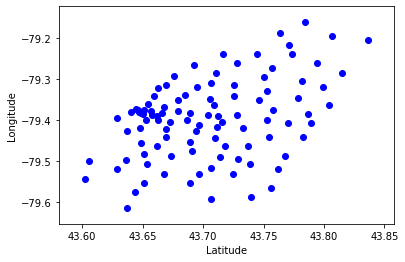

In [26]:
plt.scatter(x['Latitude'],x['Longitude'],c='blue')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

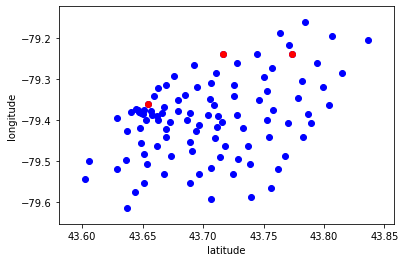

In [33]:
## calculating centroids
k=3
centroids=(x.sample(n=k))
plt.scatter(x['Latitude'],x['Longitude'],c='blue')
plt.scatter(centroids['Latitude'],centroids['Longitude'],c='red')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

In [29]:
#assigning all the oints to closet centroid
diff=1
j=0
while(diff!=0):
    xD=x
    i=1
    for index1,row_c in centroids.iterrows():
        ED=[]
        for index2,row_d in xD.iterrows():
            d1=(row_c['Latitude']-row_d['Latitude'])**2
            d2=(row_c['Longitude']-row_d['Longitude'])**2
            d=np.sqrt(d1+d2)
            ED.append(d)
        x[i]=ED
        i=i+1
    c=[]
    for index,row in x.iterrows():
        min_dist=row[1]
        pos=1
        for i in range(k):
            if row[i+1]<min_dist:
                min_dist=row[i+1]
                pos=i+1
        c.append(pos)
    x['cluster']=c
    centroids_new=x.groupby(['cluster']).mean()[['Latitude','Longitude']]
    
    if j==0:
        diff=1
        j=j+1
    else:
        diff=(centroids_new['Longitude']-centroids['Longitude']).sum()+(centroids_new['Latitude']-centroids['Latitude']).sum()
        print(diff.sum())
    centroids=x.groupby(['cluster']).mean()[['Latitude','Longitude']]

C:\Users\DELL\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0.0061424235712266295
-0.024232932835403176
-0.008435392030811784
-0.012175913951089967
0.0


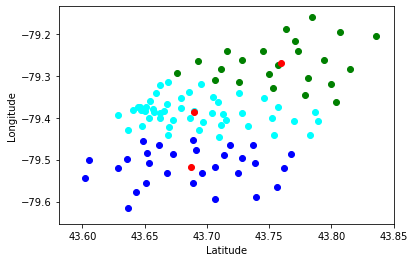

In [32]:
color=['blue','green','cyan']
for i in range(k):
    data=x[x['cluster']==i+1]
    plt.scatter(data['Latitude'],data['Longitude'],c=color[i])
plt.scatter(centroids['Latitude'],centroids['Longitude'],c='red')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.show()

## hence i got 3 clusters for the data